# Step 1, Import

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pickle

In [2]:
# filepath for instacart_basket.pkl

instacart_basket_df_filepath = '/Users/daphne/Downloads/Instacart Basket Analysis/02 Data/Prepared Data/instacart_basket_df.pkl'

In [3]:
# Open and read file


with open(instacart_basket_df_filepath, 'rb') as file:
    df_insta_full = pickle.load(file)

In [4]:
df_insta_full.shape

(32404859, 34)

In [ ]:
df_insta_full.head()

# Step 2, Address PII

In [5]:
# Drop the 'surname' column
df_insta_full = df_insta_full.drop('surname', axis=1)

In [ ]:
df_insta_full.head()

# Step 3, Region

In [6]:
# Define regions

Northeast = ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'Pennsylvania', 'New Jersey']
Midwest = ['Wisconsin', 'Michigan', 'Illinois', 'Indiana', 'Ohio', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Minnesota', 'Iowa', 'Missouri']
South = ['Delaware', 'Maryland', 'District of Columbia', 'Virginia', 'West Virginia', 'North Carolina', 'South Carolina', 'Georgia', 'Florida', 'Kentucky', 'Tennessee', 'Mississippi', 'Alabama', 'Oklahoma', 'Texas', 'Arkansas', 'Louisiana']
West = ['Idaho', 'Montana', 'Wyoming', 'Nevada', 'Utah', 'Colorado', 'Arizona', 'New Mexico', 'Alaska', 'Washington', 'Oregon', 'California', 'Hawaii']

In [7]:
# Create new 'region' column

df_insta_full['region'] = None

In [8]:
# Use loc to set the region based on the state

df_insta_full.loc[df_insta_full['state'].isin(Northeast), 'region'] = 'Northeast'
df_insta_full.loc[df_insta_full['state'].isin(Midwest), 'region'] = 'Midwest'
df_insta_full.loc[df_insta_full['state'].isin(South), 'region'] = 'South'
df_insta_full.loc[df_insta_full['state'].isin(West), 'region'] = 'West'

In [ ]:
df_insta_full.head()

In [9]:
# Create a cross-tabulation table

crosstab = pd.crosstab(df_insta_full['region'], df_insta_full['spending_flag'])

In [10]:
crosstab

spending_flag,high spender,regular spender
region,,
Midwest,155975,7441350
Northeast,108225,5614511
South,209691,10582194
West,160354,8132559


There is a differnce in spending habits by region. The Northeast region spends the least and the South and West region spend the most. This could also be because there are more states and greater populations in these regions.

# Step 4, Exclusion Flag

In [11]:
# Number of orders per customer

order_counts = df_insta_full.groupby('user_id')['order_number'].count()

In [12]:
# Create exclusion flag

def create_exclusion_flag(order_count):
    if order_count < 5:
        return 'exclude'
    else:
        return 'include'

In [13]:
# Create exclusion flag column

df_insta_full['exclusion_flag'] = df_insta_full['user_id'].map(order_counts.apply(create_exclusion_flag))

In [14]:
# Exclude low activity customers

df_filtered = df_insta_full[df_insta_full['exclusion_flag'] == 'include']

In [ ]:
df_filtered.head()

I've already exported df_filtered, this is the code I used:

"# Defining filepath

high_activity_file_path = "/Users/daphne/Downloads/Instacart Basket Analysis/02 Data/df_insta_high_act.pkl""

"# Export dataframe

df_filtered.to_pickle(high_activity_file_path)"

# Step 5, Customer Profiling

Age Group

In [16]:
df_filtered.loc[df_filtered['age'] <= 29, 'age_group'] = '18-29'
df_filtered.loc[(df_filtered['age'] > 29) & (df_filtered['age'] < 40), 'age_group'] = '30-39'
df_filtered.loc[(df_filtered['age'] > 39) & (df_filtered['age'] < 50), 'age_group'] = '40-49'
df_filtered.loc[(df_filtered['age'] > 49) & (df_filtered['age'] < 60), 'age_group'] = '50-59'
df_filtered.loc[(df_filtered['age'] > 59) & (df_filtered['age'] < 70), 'age_group'] = '60-69'
df_filtered.loc[df_filtered['age'] > 69, 'age_group'] = '70 and over'

In [17]:
df_filtered['age_group'].value_counts(dropna = False)

18-29          6089837
70 and over    6079469
40-49          5108761
30-39          5073330
50-59          5063757
60-69          4986821
Name: age_group, dtype: int64

In [ ]:
df_filtered.head()

Income Group

In [19]:
df_filtered.loc[df_filtered['income'] <= 70000, 'income_group'] = 'low'
df_filtered.loc[(df_filtered['income'] > 70000) & (df_filtered['income'] <= 120000), 'income_group'] = 'average'
df_filtered.loc[df_filtered['income'] > 100000, 'income_group'] = 'high'

In [20]:
df_filtered['income_group'].value_counts(dropna = False)

high       14813412
low         8994267
average     8594296
Name: income_group, dtype: int64

In [ ]:
df_filtered.head()

Department 

In [21]:
# filepath for departments_wrangled.csv

departments_filepath = '/Users/daphne/Downloads/Instacart Basket Analysis/02 Data/Prepared Data/dep_wrangled.csv'

In [22]:
# Read CSV file

df_dep = pd.read_csv(departments_filepath, index_col=False)

In [ ]:
df_dep

In [24]:
# merge df_dep and df_filtered

merged_df = df_filtered.merge(df_dep, on='department_id', how='inner')

In [ ]:
merged_df.head()

Number of Dependents Group

In [25]:
# Define conditions and labels

conditions = [
    (merged_df['fam_status'] == 'single') & (merged_df['n_dependants'] >= 1),
    (merged_df['fam_status'] == 'married') & (merged_df['n_dependants'] == 0),
    (merged_df['fam_status'] == 'married') & (merged_df['n_dependants'] > 0),
    (merged_df['fam_status'] == 'single') & (merged_df['n_dependants'] == 0),
    (merged_df['fam_status'] == 'divorced/widowed') & (merged_df['n_dependants'] == 0),
    (merged_df['fam_status'] == 'divorced/widowed') & (merged_df['n_dependants'] >= 1),
    (merged_df['fam_status'] == 'living with parents and siblings') & (merged_df['n_dependants'] >= 1),
    (merged_df['fam_status'] == 'living with parents and siblings') & (merged_df['n_dependants'] == 0)
]

labels = ['single_parent', 'couple', 'family', 'single_adult', 'single_adult', 'single_parent', 'single_parent', 'single_adult']


In [26]:
# Create the 'dependents_group' column 

merged_df.loc[:, 'dependents_group'] = np.select(conditions, labels, default='unknown')

In [ ]:
merged_df.head()

In [27]:
merged_df['dependents_group'].value_counts(dropna = False)

family           22754753
single_adult      8096749
single_parent     1550473
Name: dependents_group, dtype: int64

# Step 6, Visualizations

Text(0.5, 1.0, 'Age Groups by Order ')

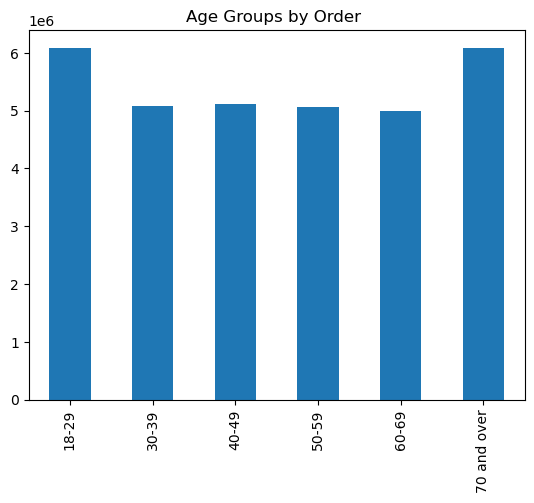

In [28]:
# Age Group Bar chart

age_group_bar = merged_df['age_group'].value_counts().sort_index().plot.bar()
plt.title('Age Groups by Order ')

Text(0.5, 1.0, 'Income Groups')

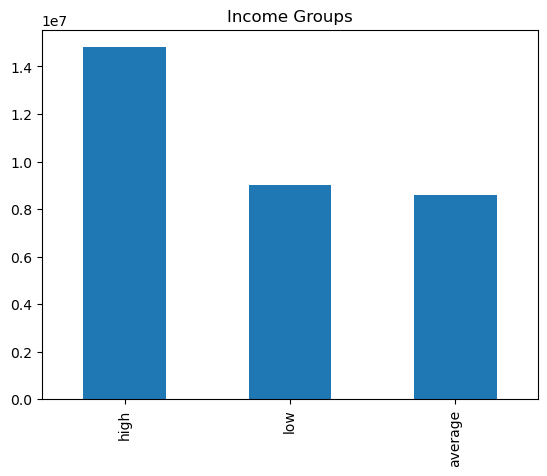

In [29]:
# Income Group Bar chart

income_group_bar = merged_df['income_group'].value_counts().plot.bar()
plt.title('Income Groups')

Text(0.5, 1.0, 'Departments')

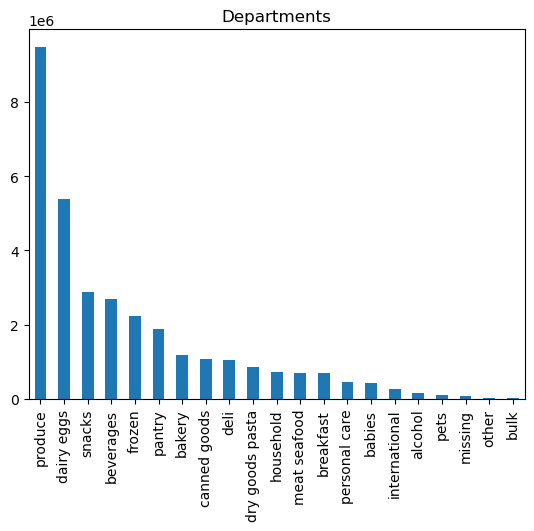

In [30]:
# Departments Bar Chart

department_group_bar = merged_df['department'].value_counts().plot.bar()
plt.title('Departments')

Text(0.5, 1.0, 'Dependents')

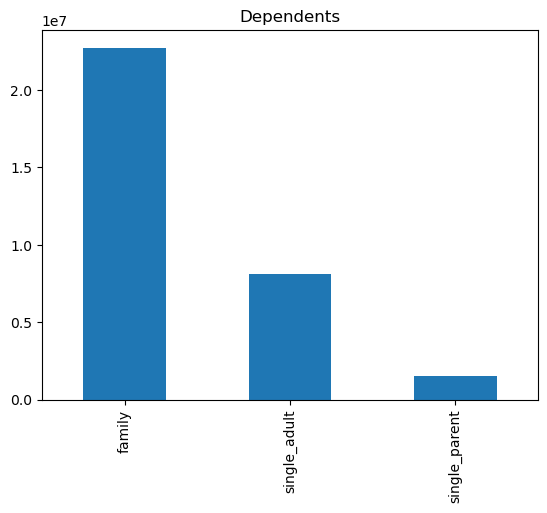

In [31]:
# Number of Dependents Group Bar chart

dependents_group_bar = merged_df['dependents_group'].value_counts().plot.bar()
plt.title('Dependents')

# Step 7, Aggregate Max, Mean, and Min

Age Group

In [32]:
age_agg = merged_df.groupby('age_group',)[['days_since_prior_order','prices']].agg(['min','max','mean'])

In [33]:
age_agg

days_since_prior_order                  prices                    
                               min   max       mean    min      max       mean
age_group                                                                     
18-29                          0.0  30.0  11.112462    1.0  99999.0  12.172472
30-39                          0.0  30.0  11.101364    1.0  99999.0  11.933667
40-49                          0.0  30.0  11.096594    1.0  99999.0  12.365443
50-59                          0.0  30.0  11.126830    1.0  99999.0  11.863113
60-69                          0.0  30.0  11.094716    1.0  99999.0  11.628252
70 and over                    0.0  30.0  11.089564    1.0  99999.0  11.874838

Income Group

In [34]:
income_agg = df_filtered.groupby('income_group',)[['days_since_prior_order','prices']].agg(['min','max','mean'])

In [35]:
income_agg

days_since_prior_order                  prices           \
                                min   max       mean    min      max   
income_group                                                           
average                         0.0  30.0  11.028730    1.0  99999.0   
high                            0.0  30.0  11.039485    1.0  99999.0   
low                             0.0  30.0  11.281023    1.0  14900.0   

                         
                   mean  
income_group             
average        8.890235  
high          16.573431  
low            7.358260

Dependents Group

In [36]:
dependents_agg = merged_df.groupby('dependents_group',)[['days_since_prior_order','prices']].agg(['min','max','mean'])

In [37]:
dependents_agg

days_since_prior_order                  prices           \
                                    min   max       mean    min      max   
dependents_group                                                           
family                              0.0  30.0  11.115541    1.0  99999.0   
single_adult                        0.0  30.0  11.080131    1.0  99999.0   
single_parent                       0.0  30.0  11.047623    1.0  99999.0   

                             
                       mean  
dependents_group             
family            12.006078  
single_adult      12.117328  
single_parent     10.829108

# Step 8, Compare Customer Profiles with Regions and Departments

In [38]:
# Age and Income by region

age_income_region = merged_df.groupby('region')[['income_group','age_group']].value_counts().reset_index(name='count')

In [39]:
age_income_region

,region,income_group,age_group,count
0,Midwest,high,70 and over,985437
1,Midwest,high,50-59,849307
2,Midwest,high,60-69,822332
3,Midwest,high,40-49,792897
4,Midwest,low,18-29,726754
...,...,...,...,...
67,West,average,50-59,222185
68,West,low,50-59,201913
69,West,low,60-69,170121
70,West,high,18-29,48349


In [40]:
# Income by region

income_region = pd.crosstab(merged_df['income_group'],merged_df['region'], dropna = False)

In [41]:
income_region

region,Midwest,Northeast,South,West
income_group,,,,
average,1969147,1526040,2916823,2182286
high,3539752,2628275,4865084,3780301
low,2087854,1567949,3008890,2329574


In [46]:
# Order count of each region

region_value_counts = merged_df['region'].value_counts().reset_index()

In [47]:
# Rename column

region_value_counts.columns = ['region', 'order_count']

In [48]:
region_value_counts

,region,order_count
0,South,10790797
1,West,8292161
2,Midwest,7596753
3,Northeast,5722264


In [51]:
# Dependents by region
dependents_region = pd.crosstab(merged_df['dependents_group'],merged_df['region'], dropna = False)

In [52]:
dependents_region

region,Midwest,Northeast,South,West
dependents_group,,,,
family,5325223,4035971,7559858,5833701
single_adult,1905043,1418193,2701405,2072108
single_parent,366487,268100,529534,386352


In [62]:
# Create crosstab for departments by dependents

departments_dependents = pd.crosstab(merged_df['department'], merged_df['dependents_group'], dropna=False)

In [63]:
departments_dependents

dependents_group,family,single_adult,single_parent
department,,,
alcohol,105647,39090,8893
babies,297154,106491,20146
bakery,821829,294390,56140
beverages,1888539,674247,124598
breakfast,493686,174567,34731
bulk,24620,8276,1674
canned goods,751999,264824,51190
dairy eggs,3788364,1349252,260773
deli,735647,265136,50410


# Step 9, Charts

Text(0, 0.5, 'Count')

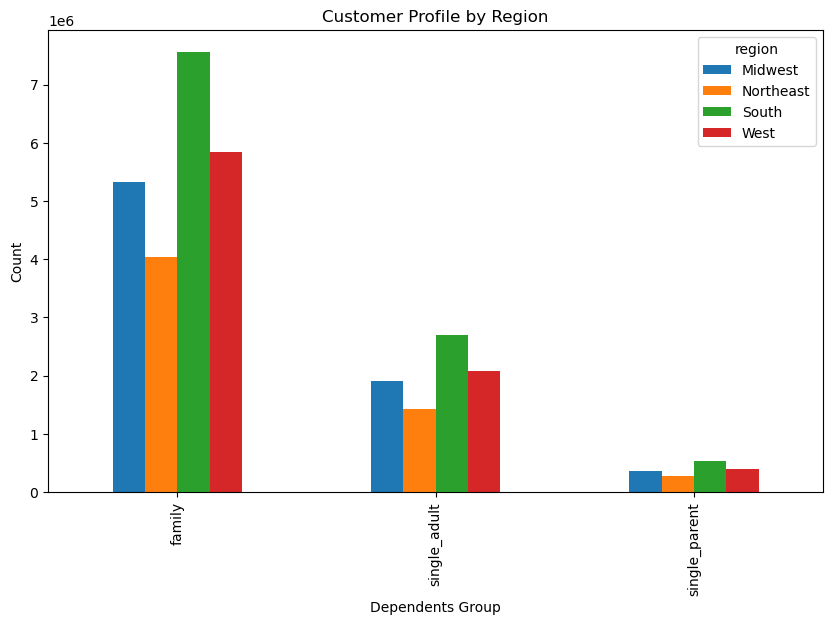

In [55]:
# Create bar chart for dependents_region

dependents_region.plot(kind='bar', figsize=(10, 6))

# Title and labels

plt.title('Customer Profile by Region')
plt.xlabel('Dependents Group')
plt.ylabel('Count')


Text(0, 0.5, 'Count')

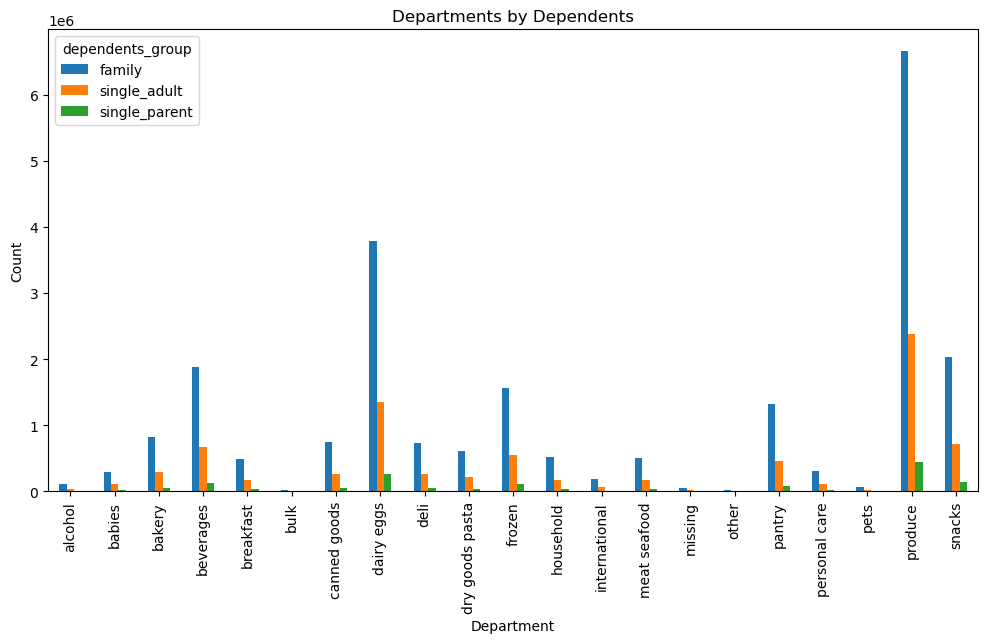

In [65]:
# Create bar chart

departments_dependents.plot(kind='bar', figsize=(12, 6))

# Set title and labels

plt.title('Departments by Dependents')
plt.xlabel('Department')
plt.ylabel('Count')

Text(0.5, 1.0, 'Order Count by Region')

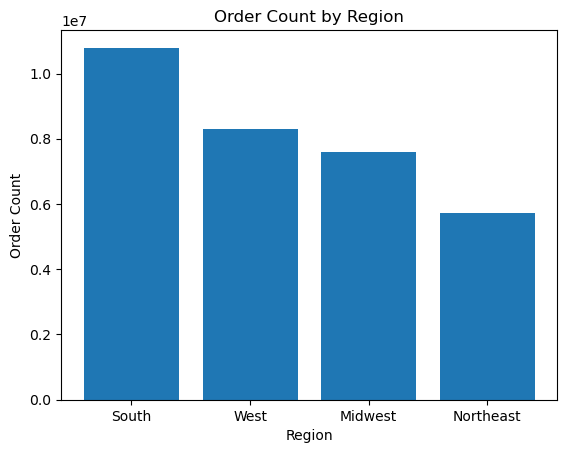

In [71]:
# Create bar chart

plt.bar(region_value_counts['region'], region_value_counts['order_count'])

# labels and title

plt.xlabel('Region')
plt.ylabel('Order Count')
plt.title('Order Count by Region')

Text(0.5, 1.0, 'Income Group by Region')

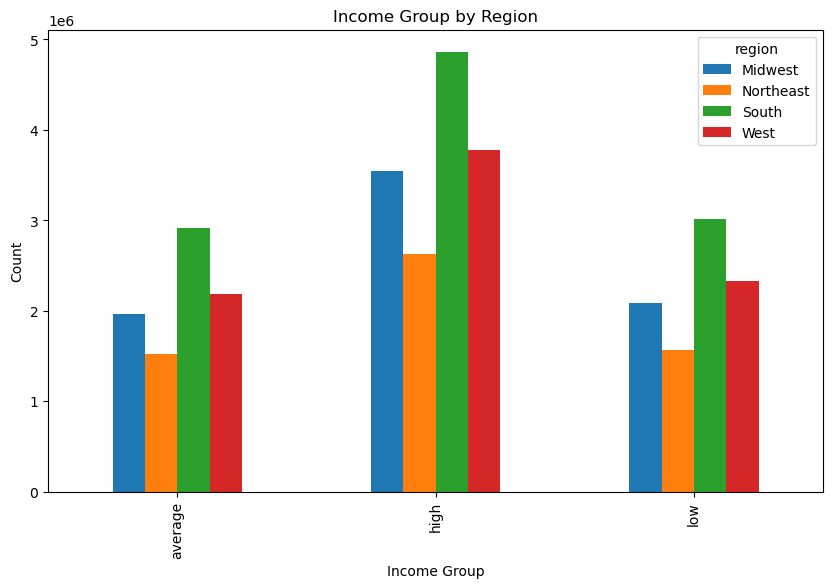

In [72]:
# Create bar chart

income_region.plot(kind='bar', figsize=(10, 6))

# labels and title
plt.xlabel('Income Group')
plt.ylabel('Count')
plt.title('Income Group by Region')


# Step 10, Export

In [73]:
# Defining filepath

file_path = "/Users/daphne/Downloads/Instacart Basket Analysis/02 Data/ords_prods_deps_merged_full.pkl"

In [74]:
# Export dataframe

merged_df.to_pickle(file_path)

In [75]:
# Comfirm export

print(f"DataFrame exported to '{file_path}' successfully.")

DataFrame exported to '/Users/daphne/Downloads/Instacart Basket Analysis/02 Data/ords_prods_deps_merged_full.pkl' successfully.
